# Impact of atmospheric CO2 concentration on precipitation

Investigating precipitation changes under different global warming scenarios (i.e., different CO2 concentrations). This project is part of the lecture *Climate Variability & Models* at FU Berlin.

**TODO**
- find a paper to get new ideas and check results
    - investigate region in particular? just one season?
- compute some precipitation index
- mask e.g. ocean
- check for certain climate regions (do dry regions become dryer and vice versa?)
- create new moisture regime map (https://storymaps.arcgis.com/stories/61a5d4e9494f46c2b520a984b2398f3b) by computing aridity index
- compute total area of dry / wet regions
- https://en.wikipedia.org/wiki/Evapotranspiration#Potential_evapotranspiration
- https://www.dwd.de/EN/ourservices/gpcc/gpcc.html
- https://www.sciencedirect.com/science/article/pii/S0031018213002320#bb0125 Good paper about which index to choose and why not use something based on evaporation!
- https://www.researchgate.net/profile/Michele-Bernardi/publication/255039317_New_gridded_maps_of_Koeppen's_climate_classification/links/02e7e52ab43b95ff2d000000/New-gridded-maps-of-Koeppens-climate-classification.pdf Warum +10 im richtigen Index!

**NOTES**
- think about units of pre
- which grid cell size?
- get "consistent" figsize

In [1]:
# DO NOT FORGET TO ACTIVATE CONDA ENV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
from scipy.optimize import curve_fit
sns.set_theme()

%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (9.6, 7.2)
#plt.rcParams["figure.dpi"] = 150

## Outline

1. **Climate simulations**: 

    I'm using three PLASIM simulation runs with CO2 concentrations of 610ppm, 790ppm & 1090ppm (numbers taken from [SSPs](#ssps)). The default (*reference*) value is 360ppm. The simulations start in 2000 and last for 30 years.
    

2. **Preprocessing** (using `cdo`-commands):

    - Compute climatology from *daily global* mean temperature for all simulations: Remove 29 Feb. Use final 10 years of simulation and compute 5-day arithmetic mean. Get climatology (i.e., single year of data) and save standard deviation.
    - Similarly for precipitation, however, keeping spatial dimensions (5-day mean or 5-day sum just differ by constant factor $\frac{1}{n}$). Create zonal plot (lat vs time) of absolute values and anomaly (ignoring significance for now).
    - Translate increase of CO2 to global warming: Compute annual mean temperature for last 10 years and average.
    - Again, similarly for precipitation: Compute annual *sum* of precipitation -> average to get single mean "equilibrium" state -> subtract *reference* to get anomaly map (a neat way to determine significant derivations between *reference* and *ssps* is [Welch's *t*-test](https://www.geo.fu-berlin.de/en/v/soga/Basics-of-statistics/Hypothesis-Tests/Hypothesis-Tests-for-Two-Population-Means/Standard-Deviations-Not-Assumed-Equal/index.html) -- highlight with black dots)
    
    (Note: Since $\overline{x_i} - \overline{y_i} = \overline{x_i - y_i}$, it doesn't matter in which order anomaly and average are computed.)
    
    
3. **Analysis** in this notebook:

    - Plot *shared socioecomonic pathways*.
    - Visualize temperature climatology.
    - Translate CO2 concentration into global warming and identify linear (?) trend.
    - Plot map of mean precipitation anomaly (with significance "marks").
    - Zonal plot to investigate temporal evolution of "equilibrium" precipitation state.

## <a name="ssps"></a> Shared Socioeconomic Pathways

The atmospheric CO2 concentration can be derived from these projected socioeconomic pathways, I use the preprocessed data from [ourworldindata](https://ourworldindata.org/explorers/ipcc-scenarios?facet=none&Metric=Greenhouse+gas+concentrations&Sub-metric=Carbon+dioxide+%28CO%E2%82%82%29&Rate=Per+capita&Region=Global&country=SSP1+-+Baseline~SSP2+-+Baseline~SSP3+-+Baseline~SSP4+-+Baseline~SSP5+-+Baseline).

In [2]:
ssps = pd.read_csv("../data/ipcc-scenarios.csv", usecols=["Scenario", "Year", "CO2 concentration"])
ssps["Scenario"].unique()
ssps

,Scenario,Year,CO2 concentration
0,SSP1 - 1.9,2005,379.85000
1,SSP1 - 1.9,2010,390.50530
2,SSP1 - 1.9,2020,412.14202
3,SSP1 - 1.9,2030,424.68152
4,SSP1 - 1.9,2040,425.52721
...,...,...,...
281,SSP5 - Baseline,2060,635.79256
282,SSP5 - Baseline,2070,730.02550
283,SSP5 - Baseline,2080,841.52016
284,SSP5 - Baseline,2090,963.84157


**Note**: Scenarios with "*scenario* - *float*" represent projected socioeconomic pathways which lead to *float* value of radiative forcing.

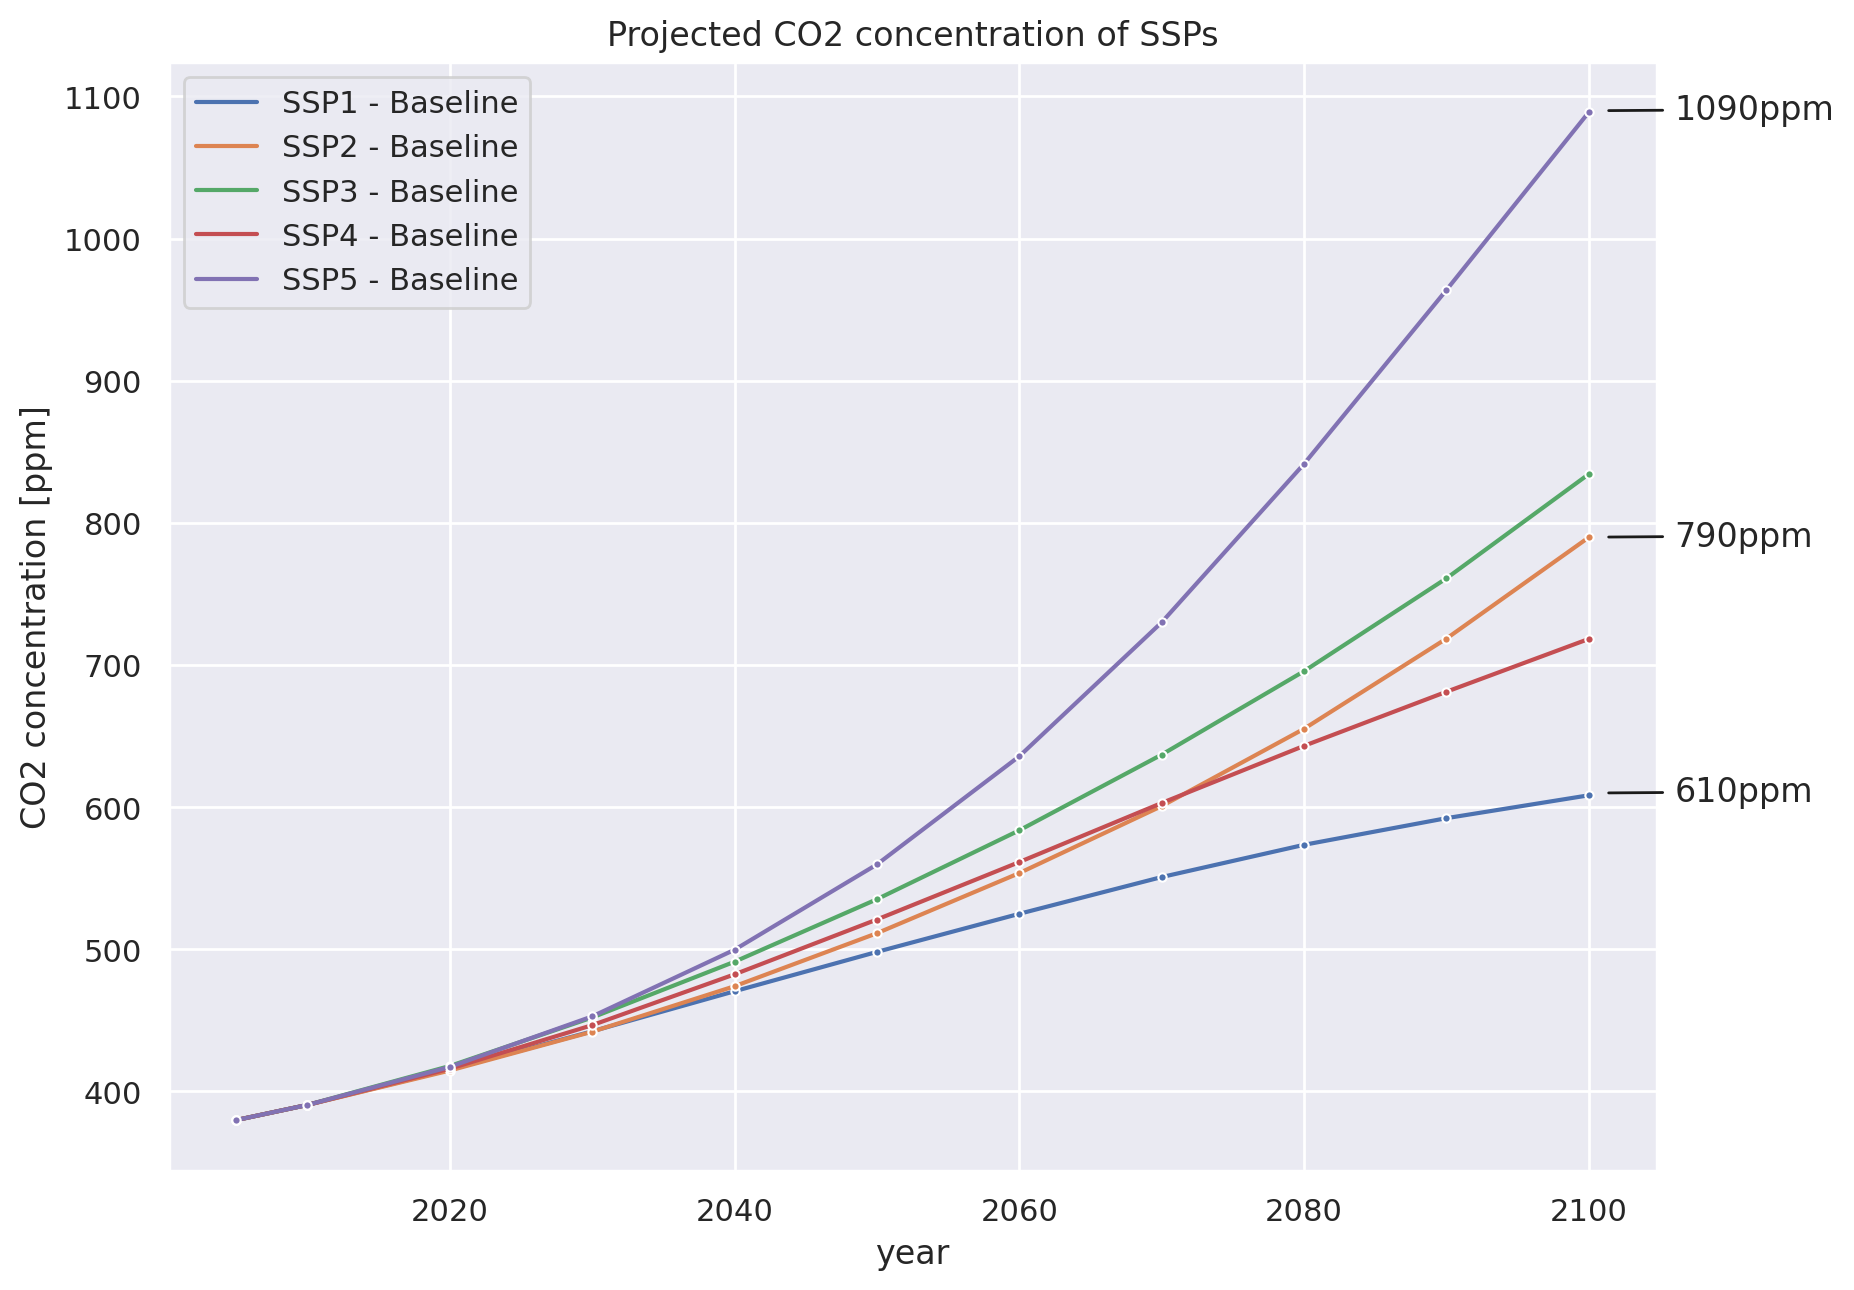

In [3]:
patternKeep = "Baseline"
filter = ssps["Scenario"].str.contains(patternKeep)
data = ssps[filter]

fig, ax = plt.subplots()
sns.lineplot(data=data, x="Year", y="CO2 concentration", hue="Scenario", marker=".", ax=ax)
ax.set_ylabel("CO2 concentration [ppm]")
ax.set_xlabel("year")
ax.set_title("Projected CO2 concentration of SSPs")
ax.legend(title=None)

for c in [610, 790, 1090]:
    ax.annotate(str(c)+"ppm", xy=(2101, c), xytext=(2106, c-6), arrowprops=dict(arrowstyle="-", color="k"))

fig.savefig("../figs/ssps-pathways.png", dpi=300, bbox_inches="tight")

## Climatology of `t2m`

In [4]:
# create datetime object from time values
def as_datetime(tlist):
    tt = []
    for t in tlist:
        tt.append(dt.date(1, 1, 1) + dt.timedelta(days=t))
    return tt

# rename reference simulation
def change_key(d):
    d["reference"] = d["plasim_ref_ln"]
    del d["plasim_ref_ln"]

Import climatology of surface temperature:

In [5]:
sims = ["plasim_ref_ln", "SSP1", "SSP3", "SSP5"]

t2m = {}
t2m_std = {}
time = {}

# get temperature values
for sce in sims:
    f = Dataset(f"../data/{sce}-tmp-clim.nc")
    time[sce] = as_datetime(f.variables["time"][:])
    # somehow, temperature has shape (73, 1, 1)
    t2m[sce] = f.variables["t2m"][:].flatten()
    f.close()

# get standard devation
for sce in sims:
    f = Dataset(f"../data/{sce}-tmp-clim-std.nc")
    t2m_std[sce] = f.variables["t2m"][:].flatten()
    f.close()
  
change_key(t2m)
change_key(t2m_std)
change_key(time)

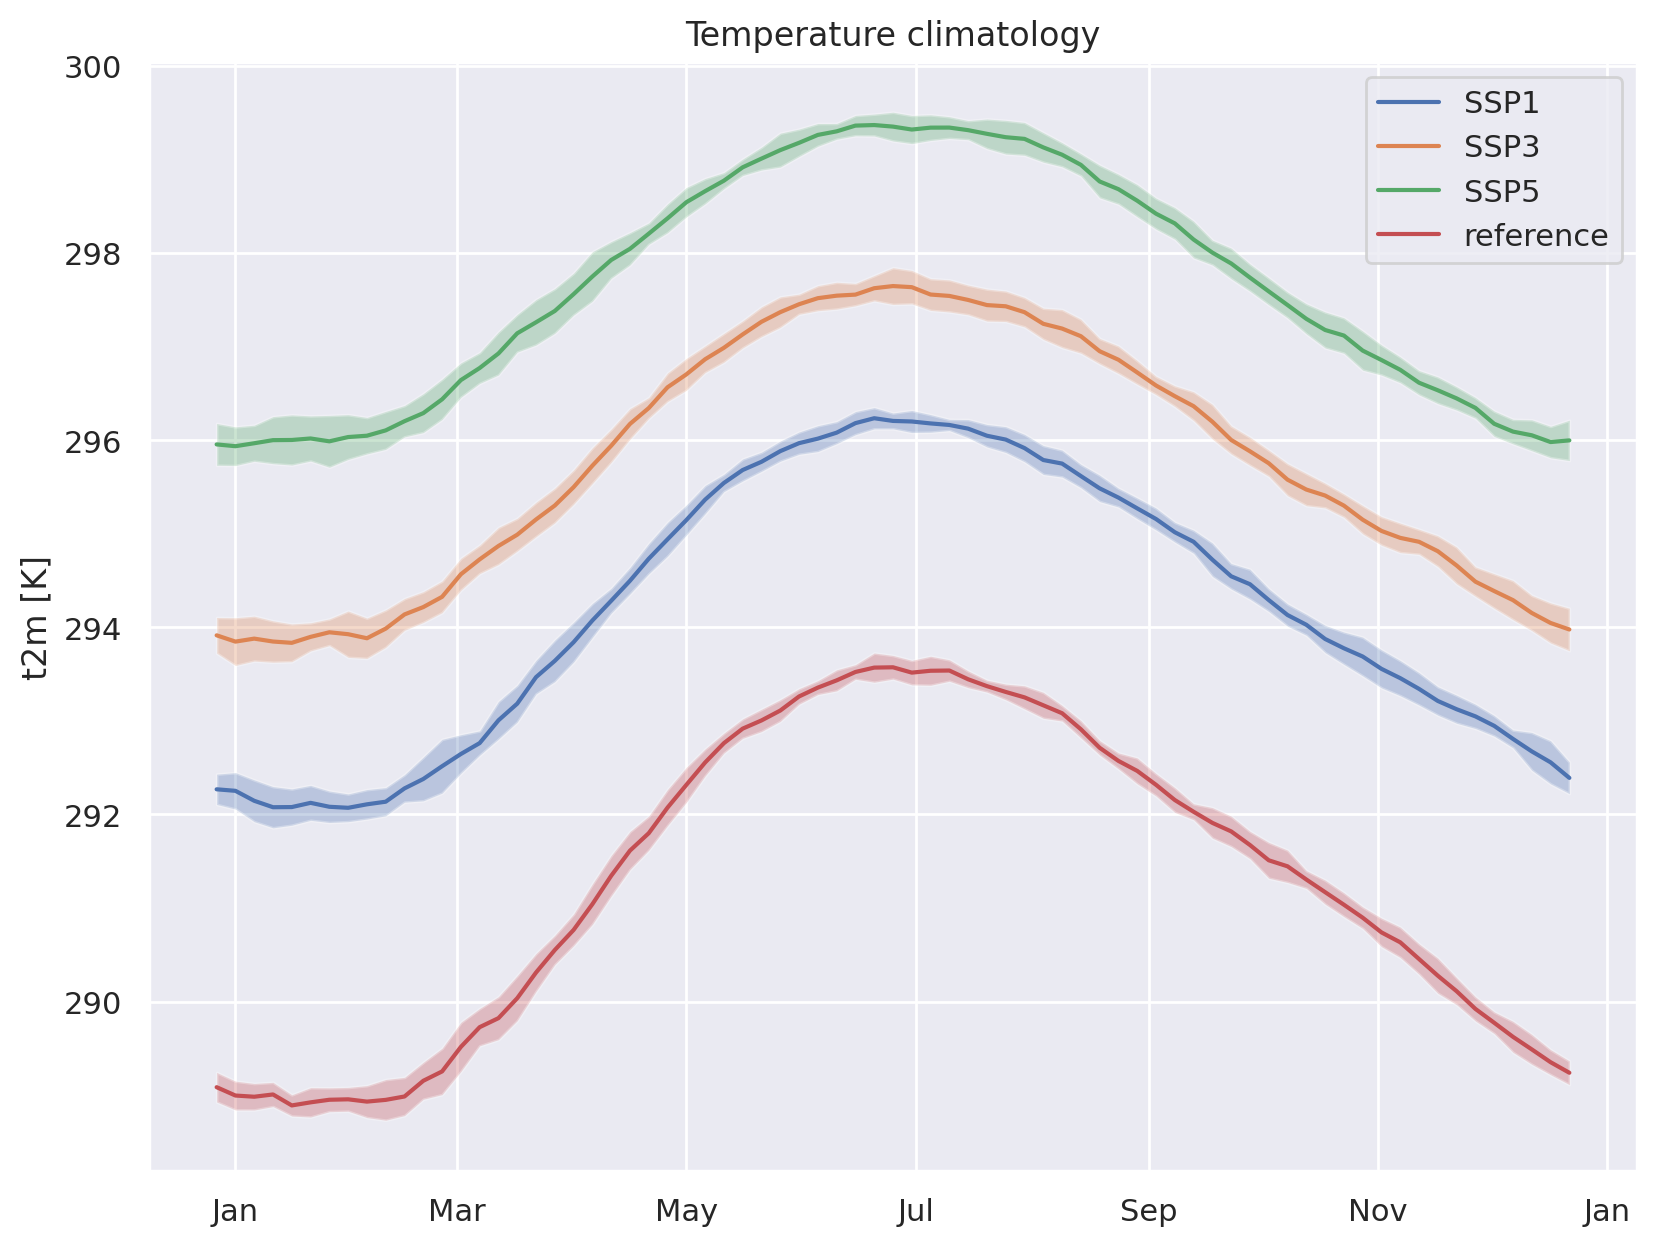

In [6]:
dt_fmt = mdates.DateFormatter('%b')

fig, ax = plt.subplots()
for sce in list(t2m.keys()):
    ax.plot(time[sce], t2m[sce], label=sce)
    ax.fill_between(time[sce], t2m[sce]-t2m_std[sce], t2m[sce]+t2m_std[sce], alpha=.3)
ax.xaxis.set_major_formatter(dt_fmt)
ax.legend()
ax.set_ylabel("t2m [K]")
ax.set_title("Temperature climatology");

## Global warming for each scenario

Import global *annual* (hence, variables are labelled with `_an`-suffix) mean surface temperature:

In [7]:
co2 = np.array([360.0, 610.0, 790.0, 1090.0]) # co2 concentration in ppm (same order as simulation names!)

t2m_an = {}
t2m_an_std = {}

# get temperature values
for cc, sce in zip(co2, sims):
    f = Dataset(f"../data/{sce}-tmp-annual.nc")
    # temperature (still) has shape (1, 1, 1)
    t2m_an[cc] = f.variables["t2m"][0,0,0]
    f.close()

# get standard devation
for cc, sce in zip(co2, sims):
    f = Dataset(f"../data/{sce}-tmp-annual-std.nc")
    t2m_an_std[cc] = f.variables["t2m"][0,0,0]
    f.close()

In [8]:
# linear fit
def linear(x, a, b):
    return a * x + b

xdata = co2
ydata = list(t2m_an.values())
yerr = list(t2m_an_std.values())

popt, pcov = curve_fit(linear, xdata, ydata, sigma=yerr)
perr = np.sqrt(np.diag(pcov))

In [9]:
# compute slope of temperature increase
print("slope:")
print(f"{np.round(popt[0], 4)} +/- {np.round(perr[0], 4)}")

# compute temperature increase ("global warming") per scenario
t2m_increase = []
t2m_increase_std = []

for c in [610.0, 790.0, 1090.0]:
    t2m_increase.append(
        t2m_an[c] - t2m_an[360.0]
    ) 
    t2m_increase_std.append(
        # error propagation (sqrt(std1**2 + std2**2))
        np.sqrt(t2m_an_std[360.0]**2 + t2m_an_std[c]**2)
    )

slope:
0.0098 +/- 0.0011


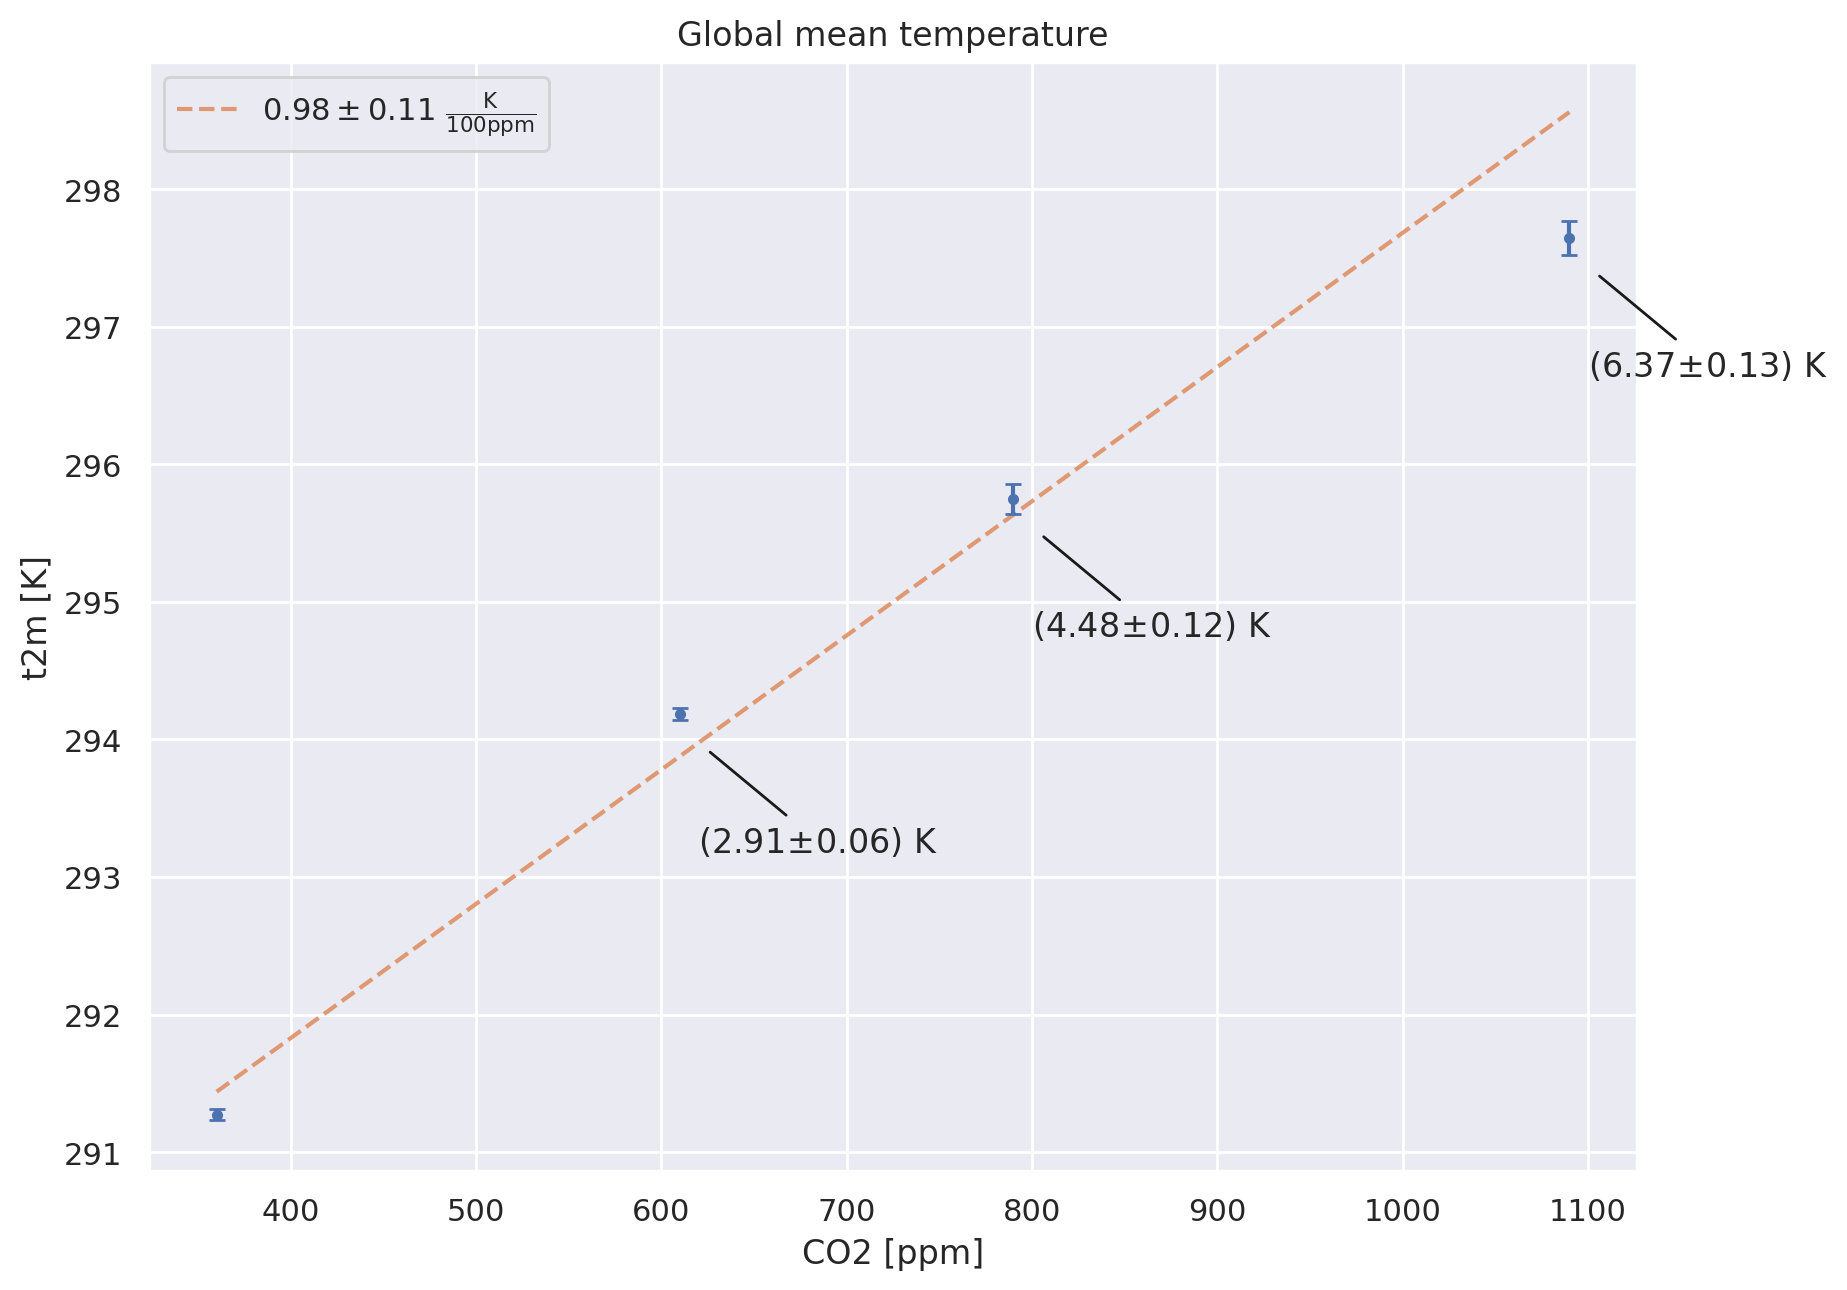

In [10]:
# plotting
fig, ax = plt.subplots()
ax.errorbar(xdata, ydata, yerr = yerr, ls="None", marker=".", capsize=3)
ax.plot(xdata, linear(xdata, *popt), ls="--", alpha=0.8, zorder=1,
        label=r"$0.98 \pm 0.11 \ \rm\frac{K}{100 ppm}$")
ax.legend()
ax.set_ylabel("t2m [K]")
ax.set_xlabel("CO2 [ppm]")
ax.set_title("Global mean temperature")

# add (global mean) temperature increase
for i, c in enumerate([610.0, 790.0, 1090.0]):
    ax.annotate("(" + str(np.round(t2m_increase[i], 2)) + r"$\! \pm\! $" + str(np.round(t2m_increase_std[i], 2)) + ") K",
                xy=(c+14, t2m_an[c]-0.25), xytext=(c+10, t2m_an[c]-1),
                arrowprops=dict(arrowstyle="-", color="k"))

# TODO: compare with literature values

## Climatology of `pr`

The model outputs *daily* values of precipitation in units of $\rm\frac{m}{s}$, hence, multiplying by $3600 \cdot 24 \cdot 1000 = 864 \cdot 10^5$ yields units of $\frac{mm}{day}$. **Quick reminder**: The climatologies are based 1) on the last ten years of the simulation and 2) on 5-day multi-year means. 

**Note**: In the pre-processing step I didn't use the global mean (`_gmean`) values in order to preserve the spatial dimension.

In [11]:
pr = {}
pr_std = {}

# get precipitation values
for sce in sims:
    f = Dataset(f"../data/{sce}-pre-clim.nc")
    pr[sce] = f.variables["pr"][:] * 864e5
    
# get standard deviation
for sce in sims:
    f = Dataset(f"../data/{sce}-pre-clim-std.nc")
    pr_std[sce] = f.variables["pr"][:] * 864e5

change_key(pr)
change_key(pr_std)
    
lon = f.variables["lon"][:]
lat = f.variables["lat"][:]
time = as_datetime(f.variables["time"][:])

f.close()

### Global mean

In [12]:
def gm(data, lat):
    # zonal mean
    data_zm = np.mean(data, axis=2)
    # meridional mean
    w = np.cos(np.deg2rad(lat))
    data_gm = np.average(data_zm, weights=w, axis=1)
    return data_gm

pr_gm = {}
pr_std_gm = {}

for sce in list(pr.keys()):
    pr_gm[sce] = gm(pr[sce], lat)
    pr_std_gm[sce] = gm(pr_std[sce], lat)

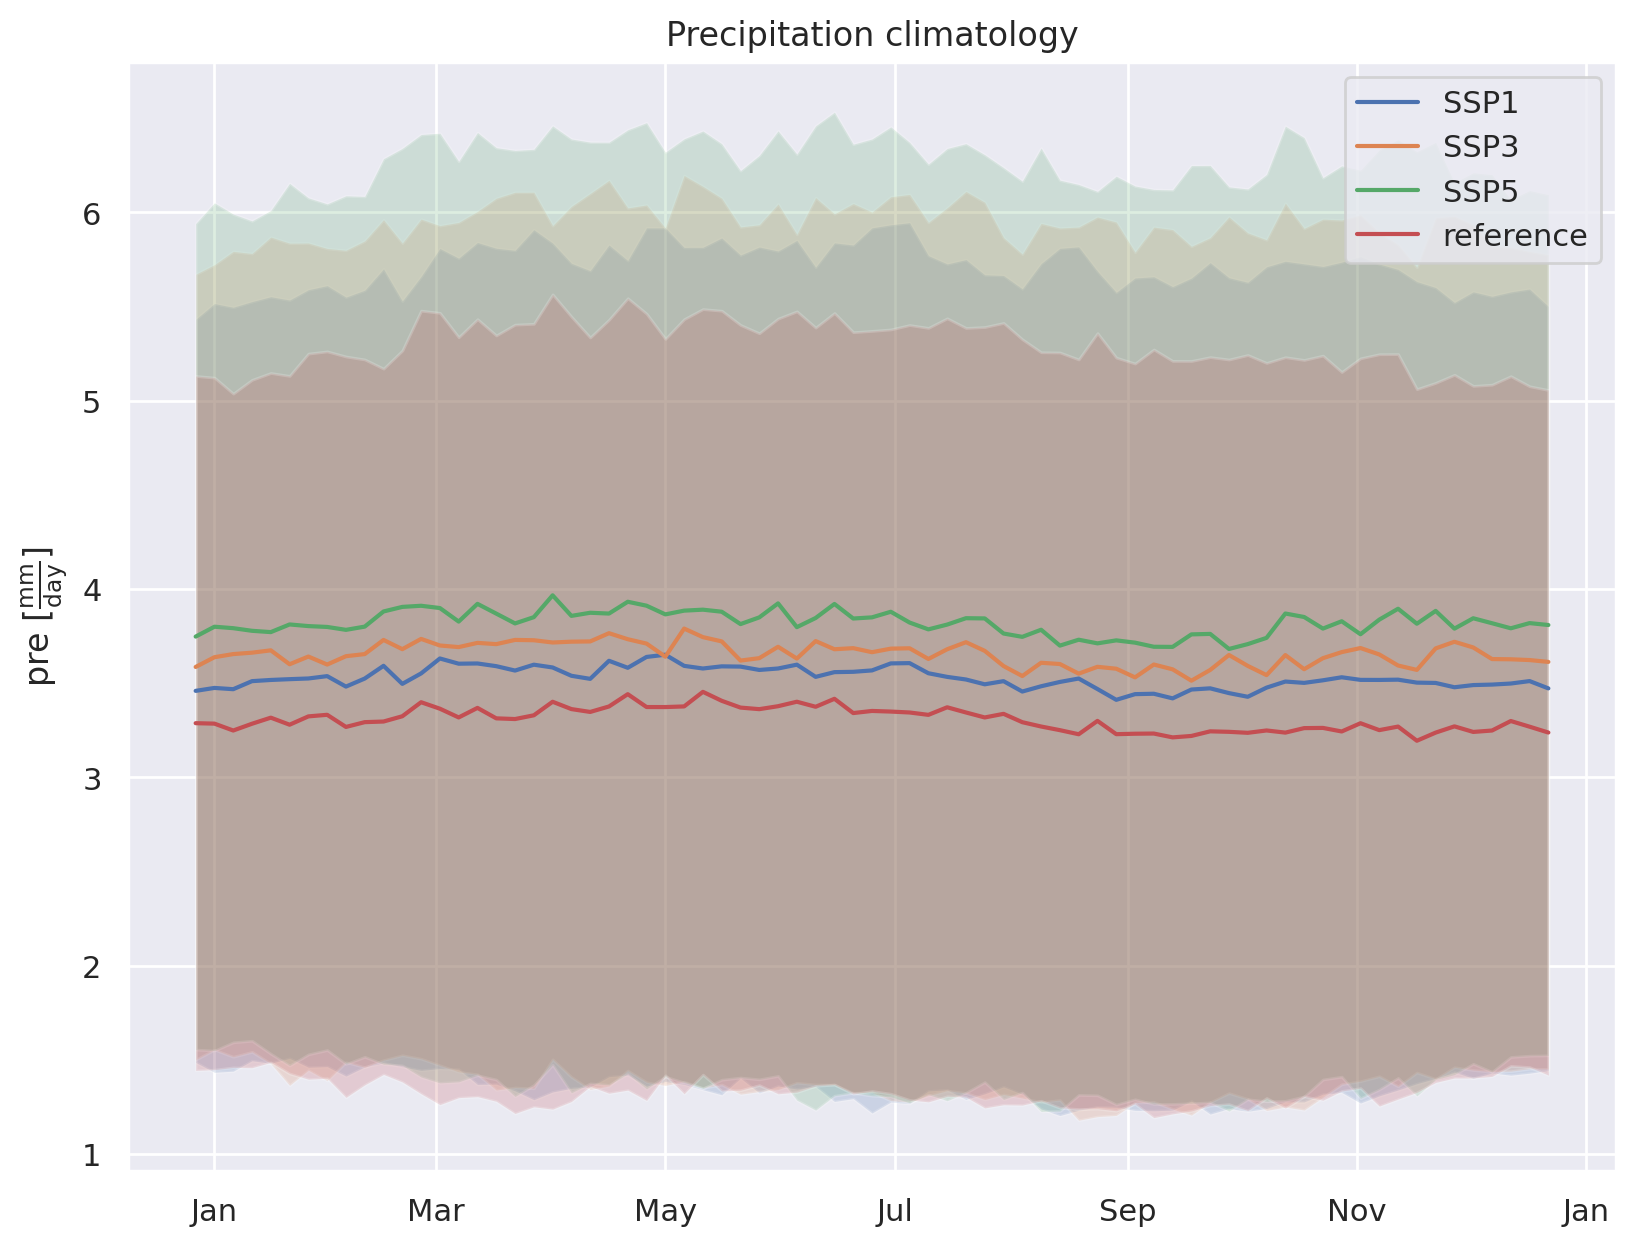

In [13]:
fig, ax = plt.subplots()
for sce in list(pr_gm.keys()):
    ax.plot(time, pr_gm[sce], label=sce)
    ax.fill_between(time, pr_gm[sce]-pr_std_gm[sce], pr_gm[sce]+pr_std_gm[sce], alpha=.2)
ax.xaxis.set_major_formatter(dt_fmt)
ax.legend()
ax.set_ylabel(r"pre [$\rm\frac{mm}{day}$]")
ax.set_title("Precipitation climatology");

### Zonal mean

In [14]:
# zonal mean
pr_zm = {}

for sce in list(pr.keys()):
    pr_zm[sce] = np.mean(pr[sce], axis=2)
    
np.shape(pr_zm[sims[1]])

(73, 32)

In [15]:
xtime, ylat = np.meshgrid(time, lat)
np.shape(xtime)

(32, 73)

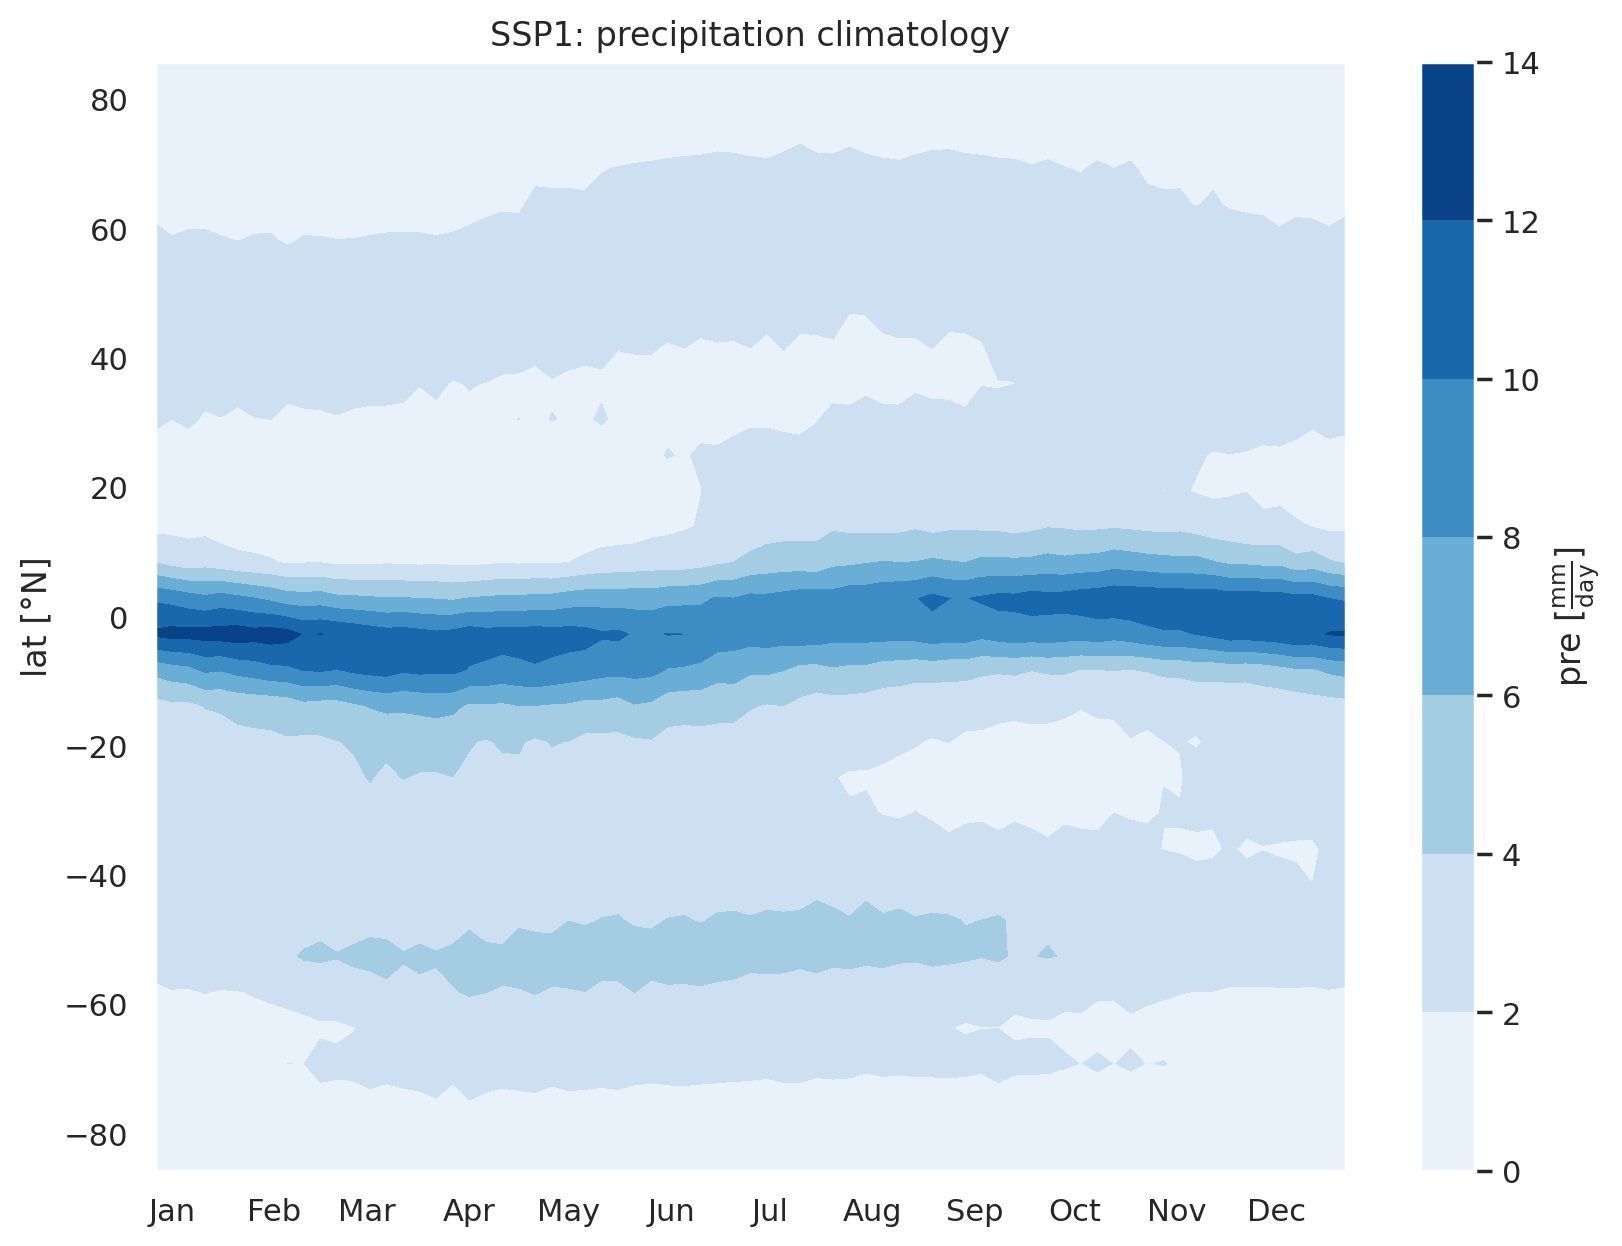

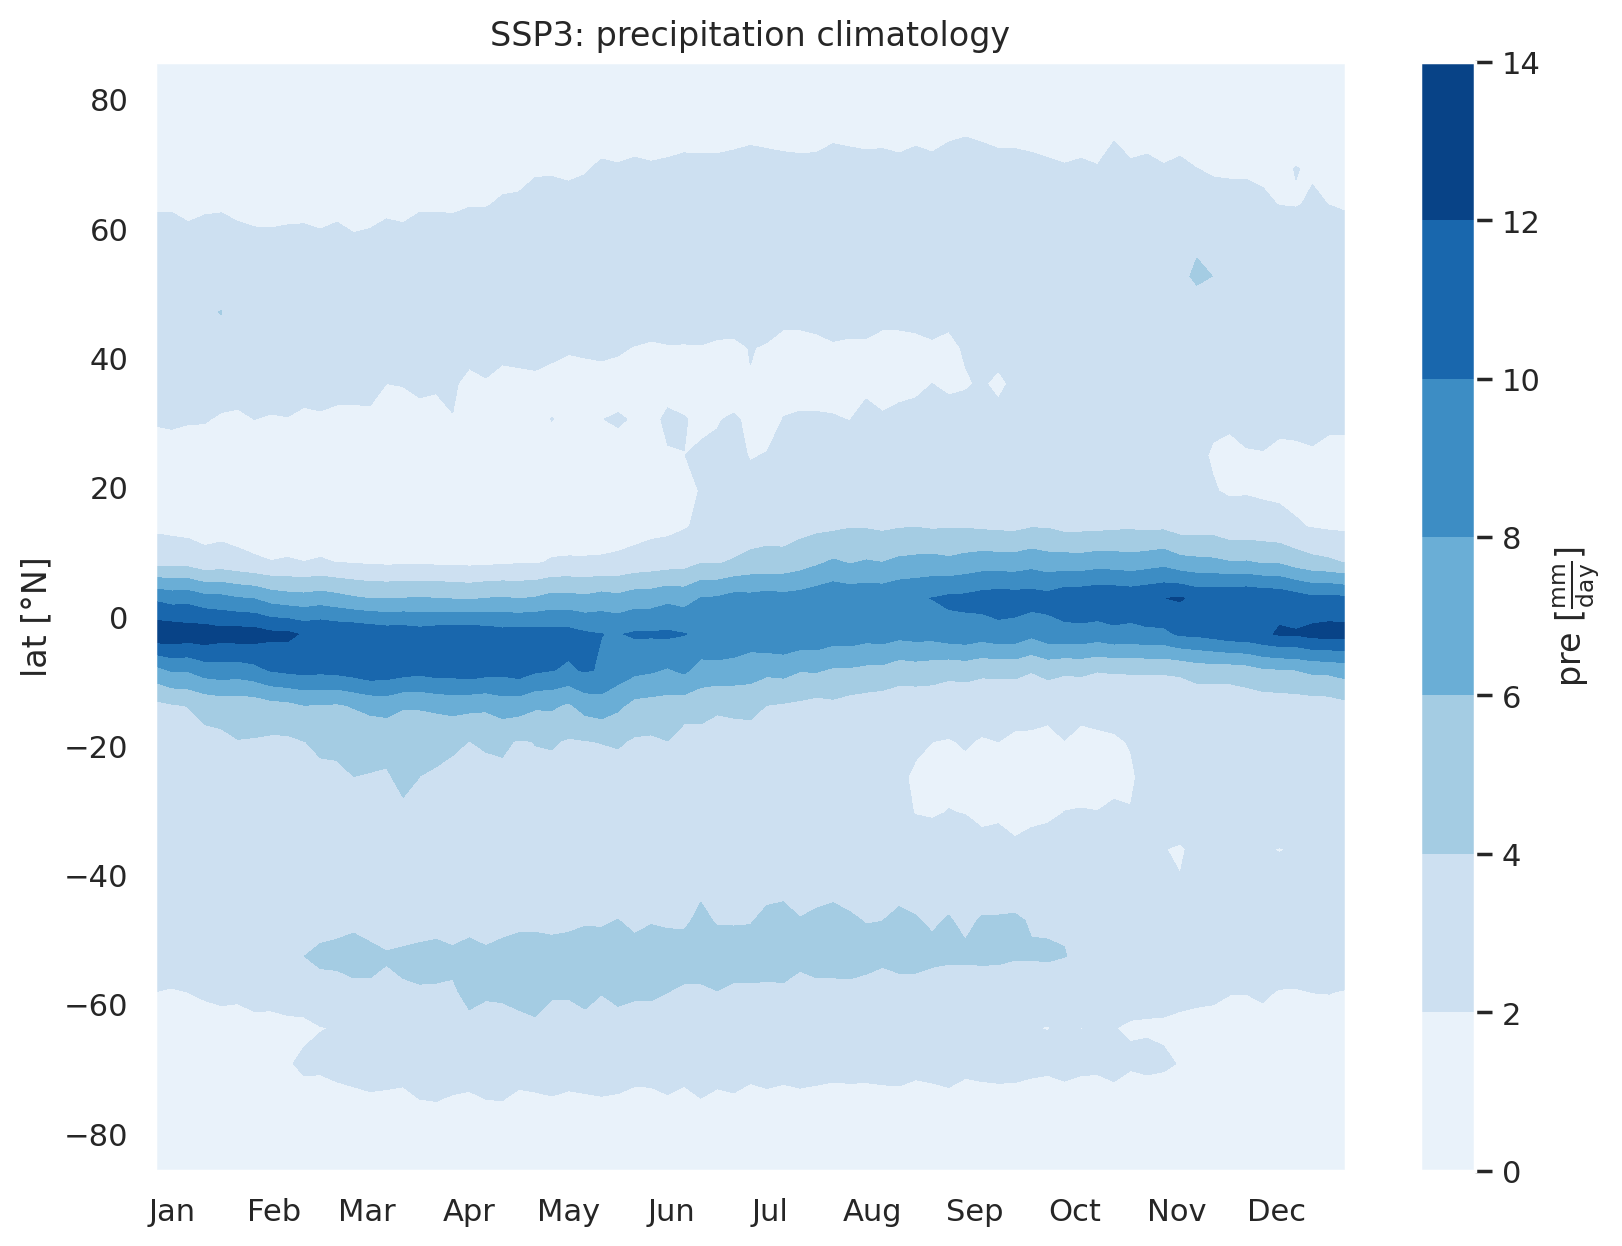

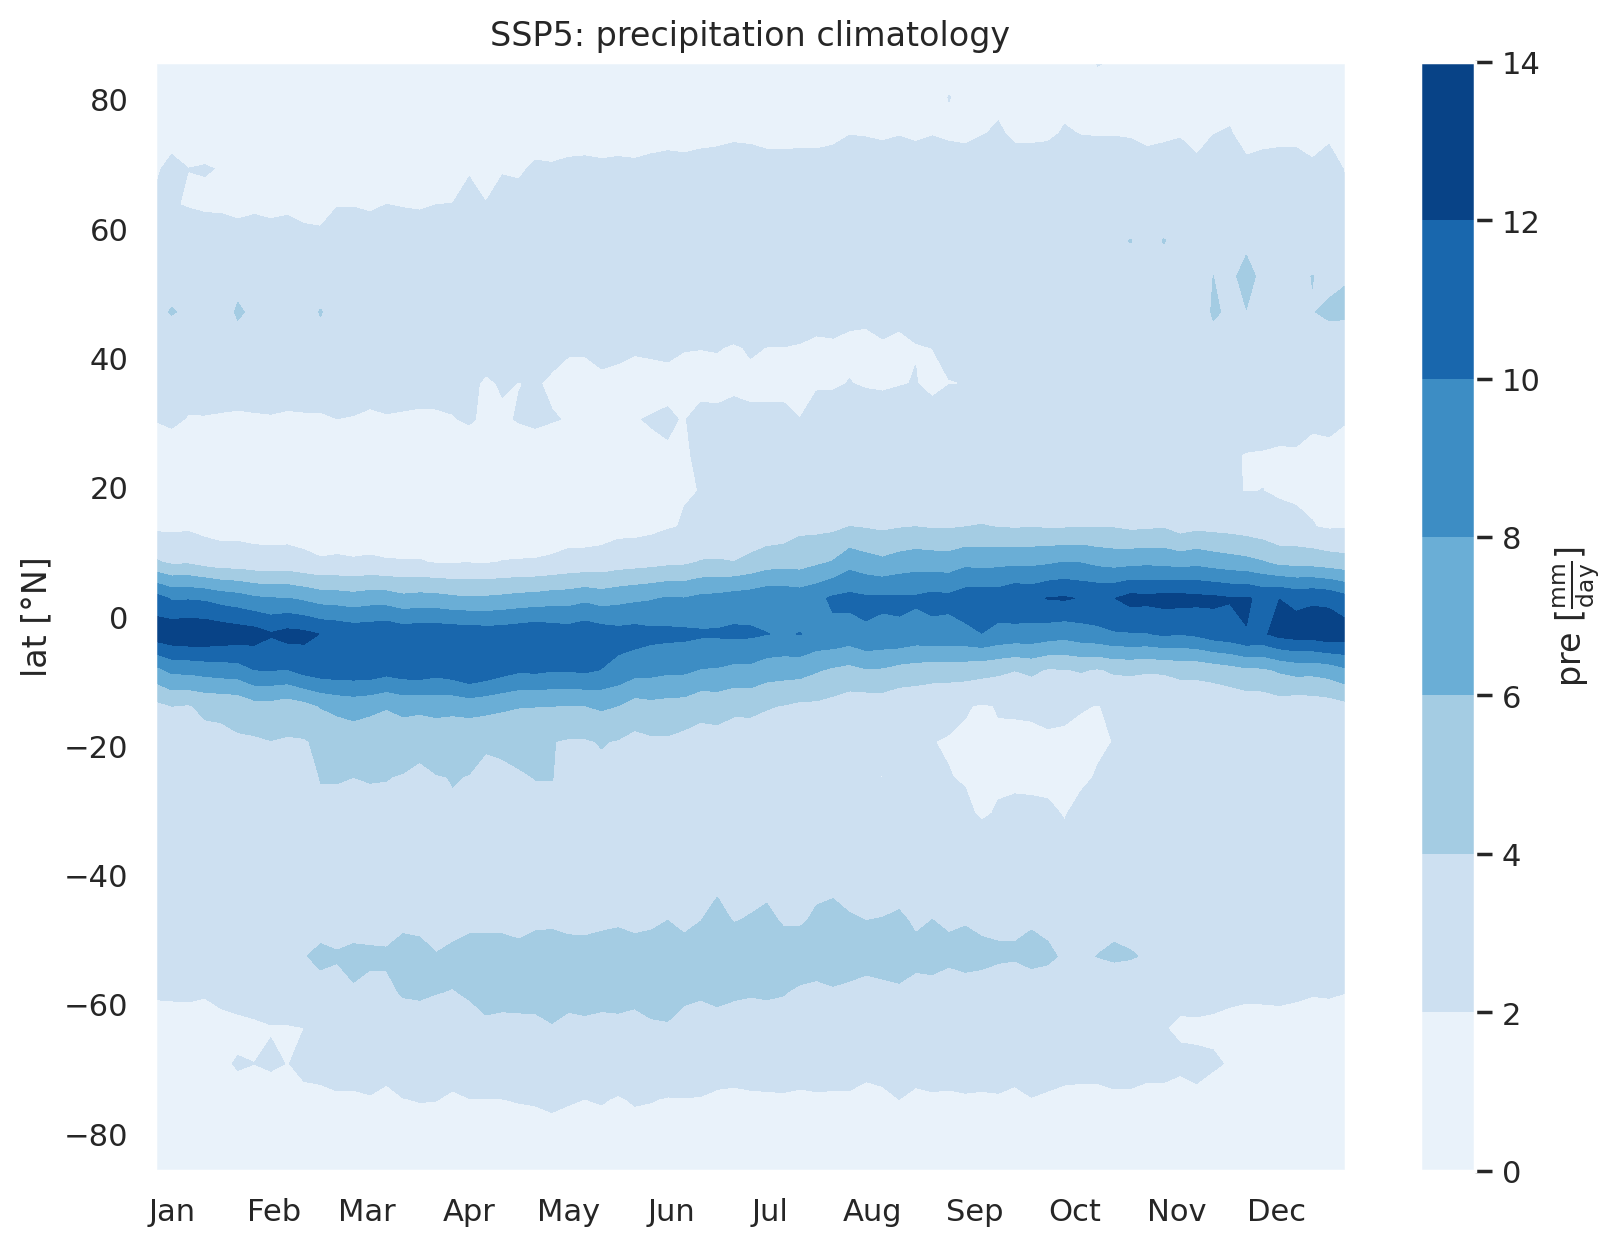

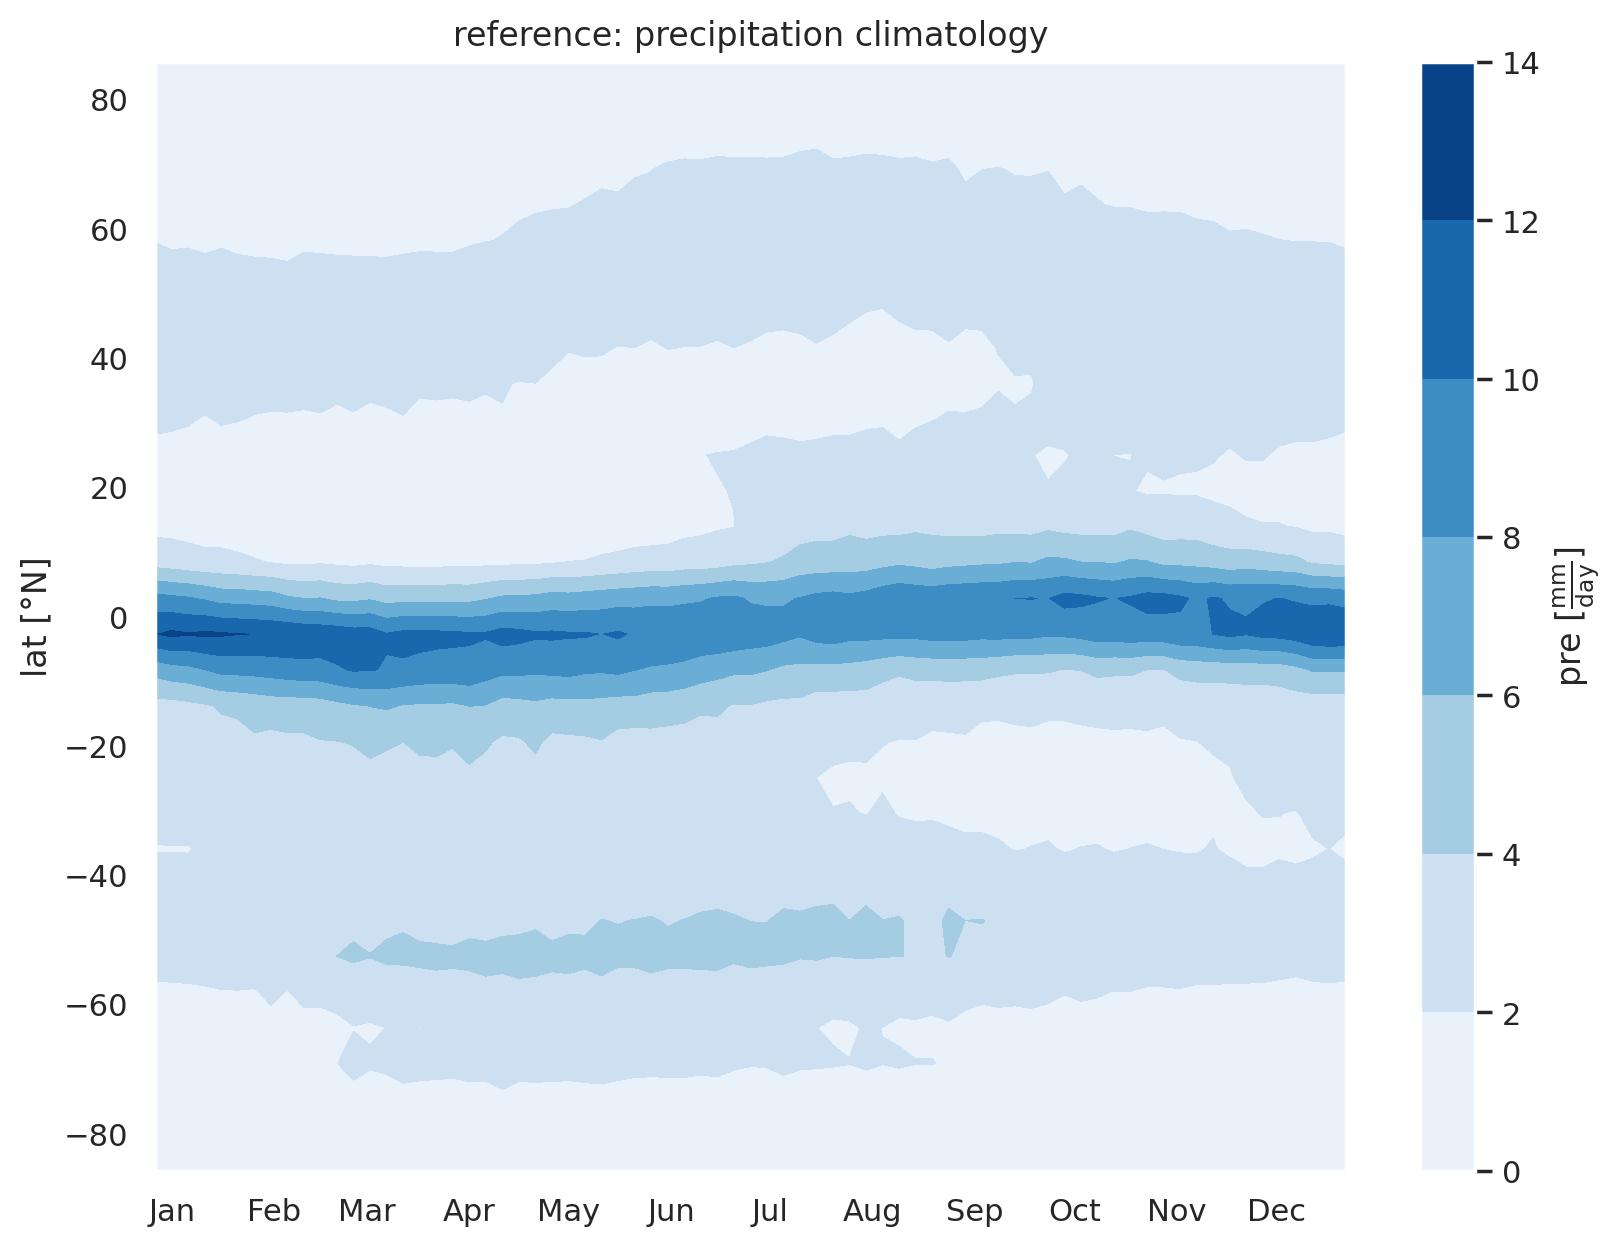

In [16]:
for sce in list(pr.keys()):
    fig, ax = plt.subplots()
    cf = ax.contourf(xtime, ylat, np.transpose(pr_zm[sce]), cmap="Blues")
    cb = fig.colorbar(cf)
    cb.set_label(r"pre [$\rm\frac{mm}{day}$]")
    ax.xaxis.set_major_formatter(dt_fmt)
    ax.set_title(f"{sce}: precipitation climatology")
    ax.set_ylabel("lat [°N]")

### Anomaly of zonal mean

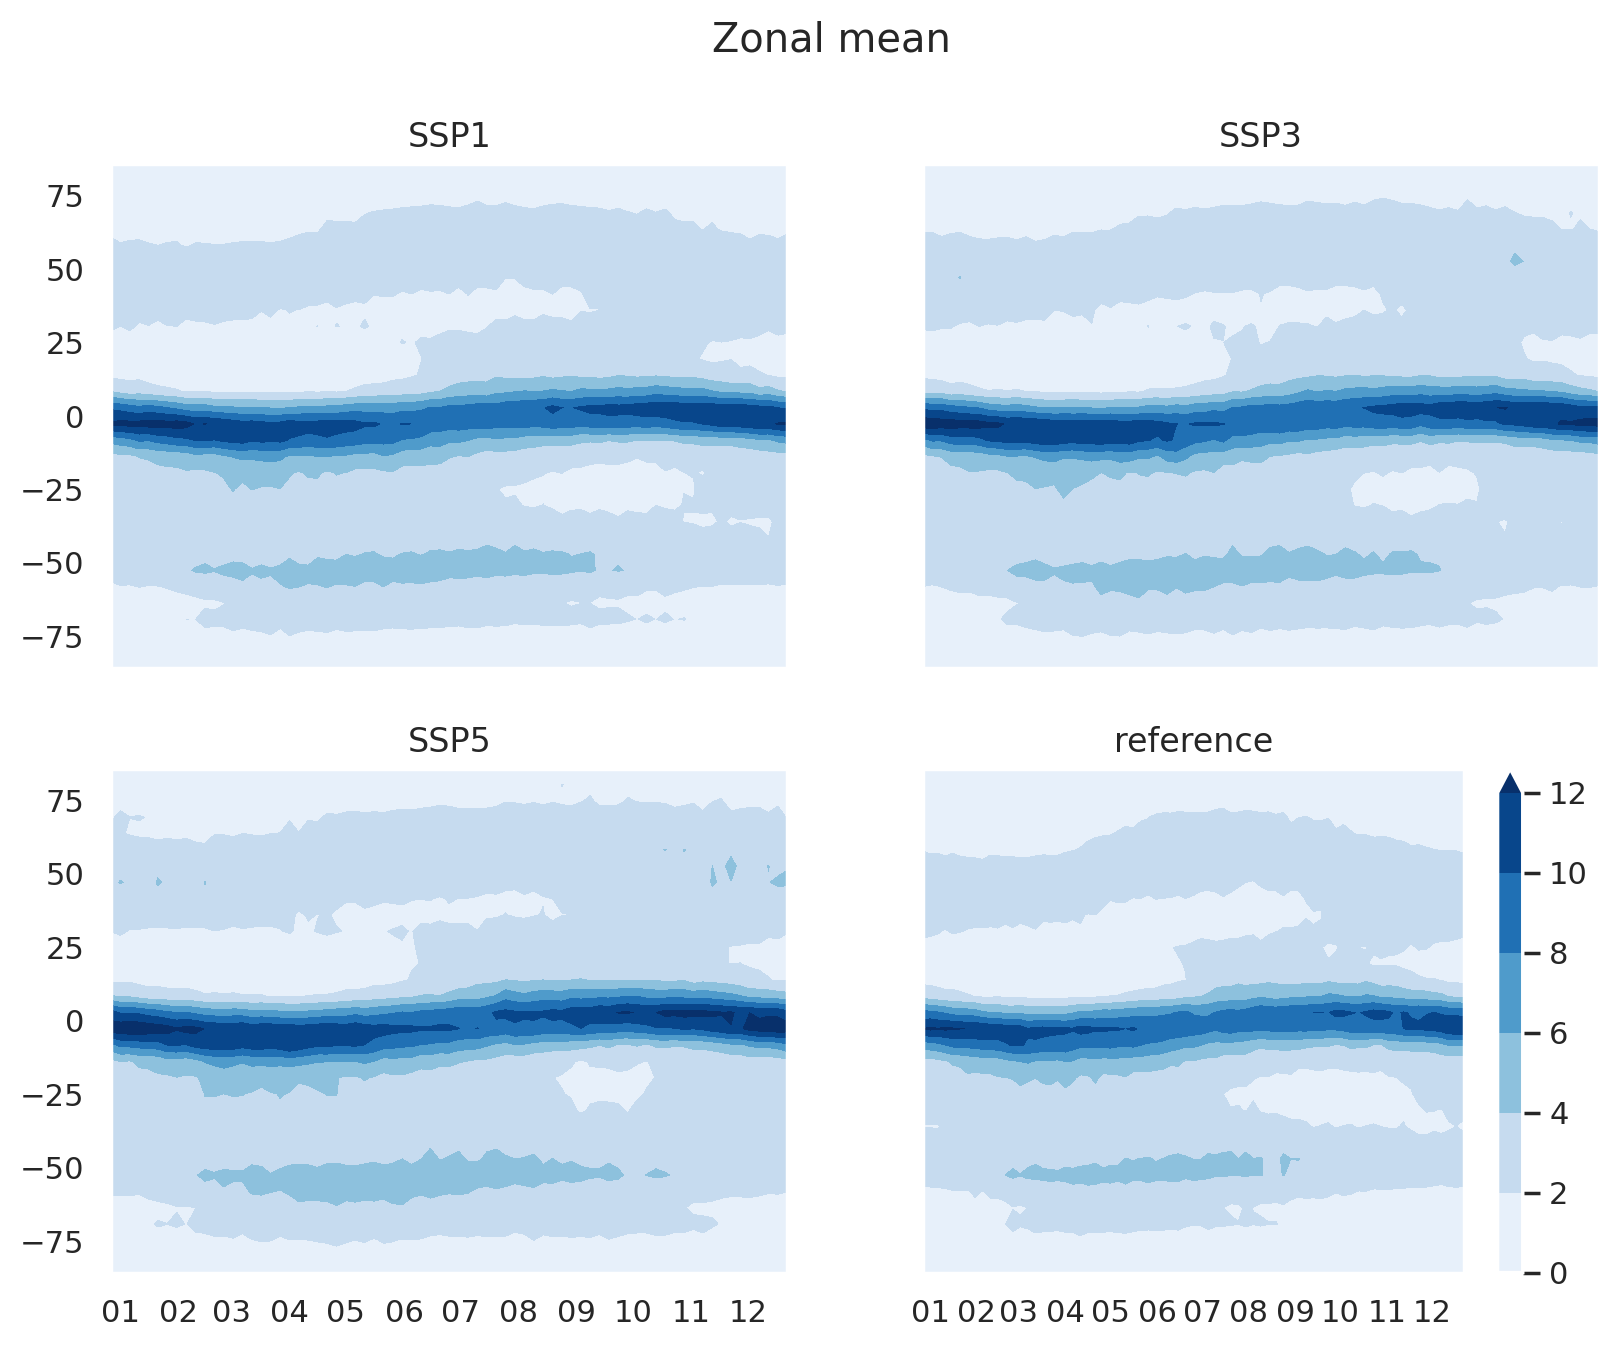

In [33]:
# set vmin and vmax if colorbars differ!
# https://stackoverflow.com/questions/67165630/one-colorbar-to-indicate-data-range-for-multiple-subplots-using-matplotlib
# how to plot one colorbar:
# https://jdhao.github.io/2017/06/11/mpl_multiplot_one_colorbar/

month_fmt = mdates.DateFormatter('%m')

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs = axs.flatten()

for i, sce in enumerate(list(pr.keys())):
    cf = axs[i].contourf(xtime, ylat, np.transpose(pr_zm[sce]), cmap="Blues", extend="max")
    #cb = fig.colorbar(cf)
    #cb.set_label(r"pre [$\rm\frac{mm}{day}$]")
#axs[i].xaxis.set_major_formatter(dt_fmt)
    axs[i].set_title(str(sce))
#axs[i].set_ylabel("lat [°N]")

fig.suptitle("Zonal mean")
axs[2].xaxis.set_major_formatter(month_fmt)
axs[3].xaxis.set_major_formatter(month_fmt)
cb = fig.colorbar(cf)

In [18]:
pr

{'SSP1': masked_array(
   data=[[[0.6529161 , 0.68010545, 0.7350998 , ..., 0.6579471 ,
           0.6205127 , 0.638544  ],
          [0.64160174, 0.55425274, 0.50762886, ..., 0.30418572,
           0.51771253, 0.6687854 ],
          [1.7673156 , 1.0250643 , 1.0907689 , ..., 0.5066524 ,
           1.1049057 , 1.6342988 ],
          ...,
          [1.2516991 , 1.1913648 , 1.3140544 , ..., 2.8088162 ,
           2.0919156 , 1.4712697 ],
          [0.8911056 , 0.7658799 , 0.7137883 , ..., 1.2964145 ,
           1.1025229 , 0.92395025],
          [0.97358406, 0.9547678 , 0.9467635 , ..., 0.97656864,
           0.9765958 , 0.9889628 ]],
 
         [[1.0725733 , 1.0777873 , 1.0878758 , ..., 1.0847905 ,
           1.0839635 , 1.0789559 ],
          [0.751876  , 0.6010114 , 0.45222238, ..., 0.60951686,
           0.8223622 , 0.91310275],
          [1.6187965 , 0.80357724, 1.0374167 , ..., 0.36587363,
           0.9082242 , 1.4331772 ],
          ...,
          [1.7231973 , 1.5304935 , 1.5882821

In [126]:
# compute anomaly
pr_zm_anom = {}

for sce in list(pr_zm.keys()):
    pr_zm_anom[sce] = pr_zm[sce] - pr_zm["reference"]

In [136]:
# meaningful colormap
v = np.max(np.absolute(pr_zm_anom["SSP5"]))
v

3.22841e-08

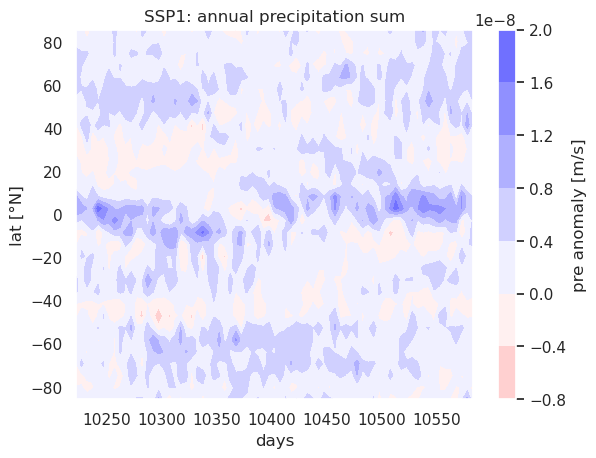

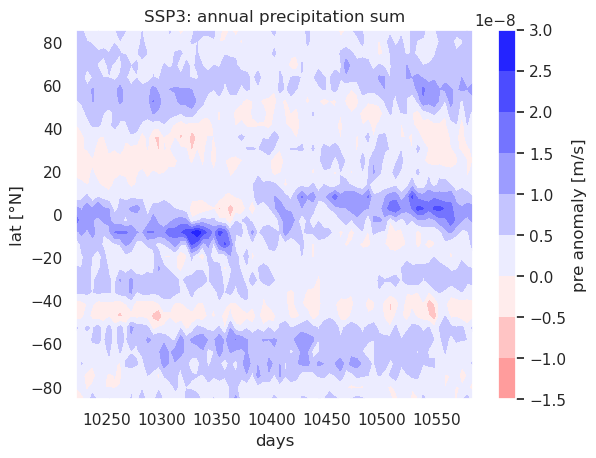

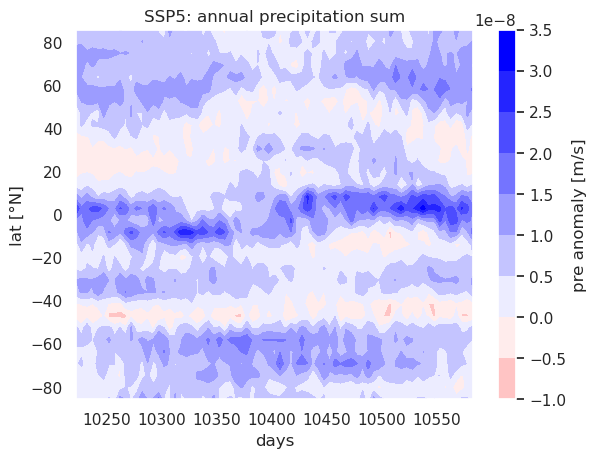

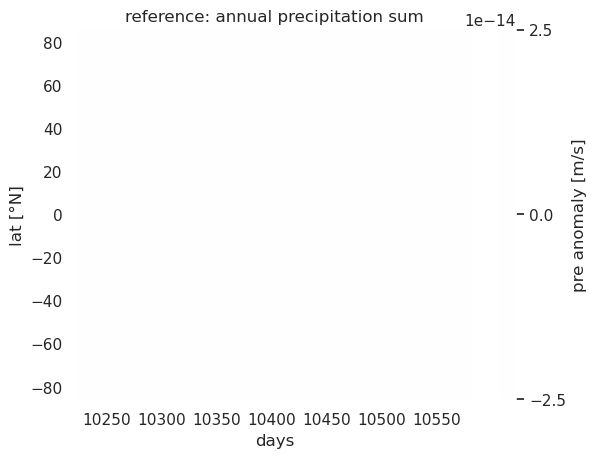

In [137]:
for sce in list(pr.keys()):
    fig, ax = plt.subplots()
    cf = ax.contourf(xtime, ylat, np.transpose(pr_zm_anom[sce]), cmap="seismic_r", vmin=-v, vmax=v)
    cb = fig.colorbar(cf)
    cb.set_label("pre anomaly [m/s]")
    ax.set_title(f"{sce}: annual precipitation sum")
    ax.set_xlabel("days")
    ax.set_ylabel("lat [°N]")
    
# TODO: small values should be in white
#       read about water vapour and precipitation

## Anomaly map of `pr`

## Precipitation

In [52]:
pr = {}

# get precipitation values
for sce in sims:
    f = Dataset(f"../data/{sce}-pre-clim.nc")
    pr[sce] = f.variables["pr"][:].reshape(32, 64)

change_key(pr)
    
lon = f.variables["lon"][:]
lat = f.variables["lat"][:]

xlon, ylat = np.meshgrid(lon, lat)

# TODO: Change unit of precipitation

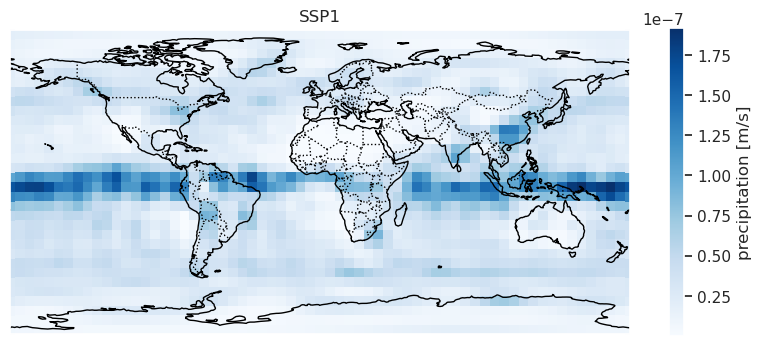

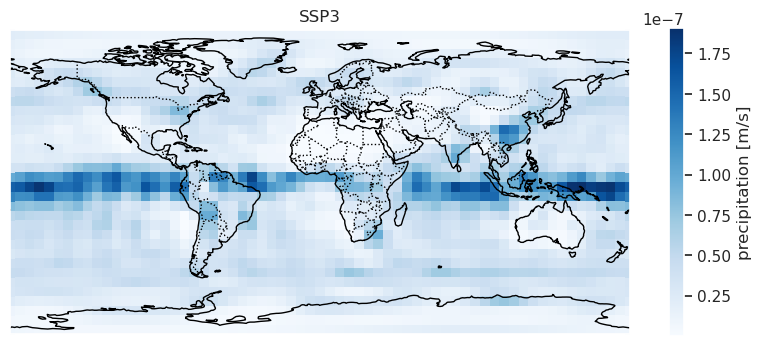

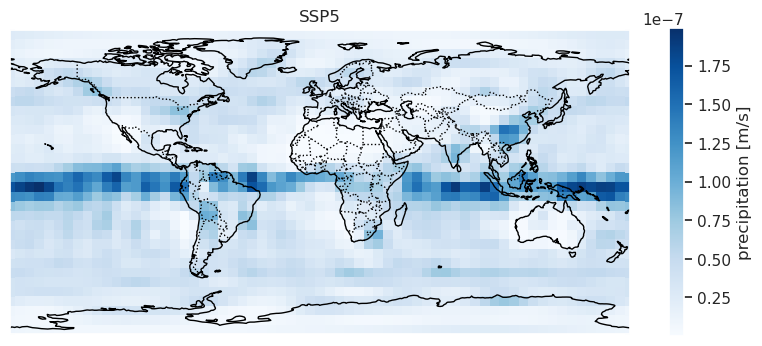

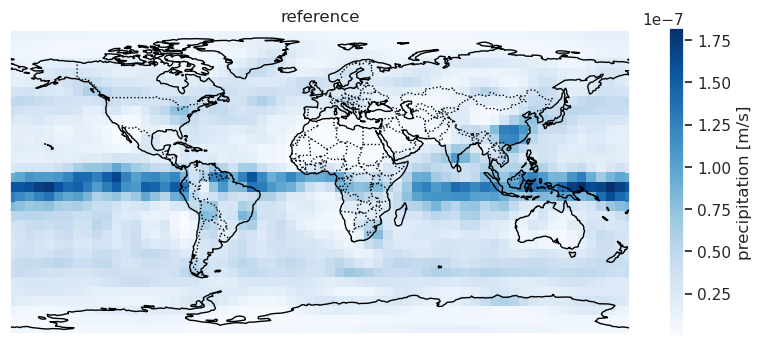

In [53]:
trans = ccrs.PlateCarree()
proj = ccrs.PlateCarree()

for sce in list(pr.keys()):
    fig, ax = plt.subplots(figsize=(10,4), subplot_kw={"projection": proj})
    cm = ax.pcolormesh(xlon, ylat, pr[sce], transform=trans, cmap="Blues")
    cb = fig.colorbar(cm)
    cb.set_label("precipitation [m/s]")
    ax.set_title(sce)
    ax.add_feature(cfeature.BORDERS, ls=":")
    ax.add_feature(cfeature.COASTLINE)

## Anomalies?